In [1]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe



from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


import folium # map rendering library
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


In [2]:
# Shenton Way, District 01, Singapore
address = 'Mccallum Street, Singapore'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore home are {}, {}.'.format(latitude, longitude))

C:\Users\Juan Raul Garcia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Singapore home are 1.2792423, 103.8481312.


In [3]:
neighborhood_latitude=1.2792655
neighborhood_longitude=103.8480938

In [4]:
CLIENT_ID = '54GU41KXZPLVE2IUFD2TSPOJVTLCROC1VTWAEYK3YEKIBYU5' # your Foursquare ID
CLIENT_SECRET = 'P2DVHDL0WHSWNSZHSWKJBEBZXRROKWDO2APFCQWQ1CJMFJMG' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 54GU41KXZPLVE2IUFD2TSPOJVTLCROC1VTWAEYK3YEKIBYU5
CLIENT_SECRET:P2DVHDL0WHSWNSZHSWKJBEBZXRROKWDO2APFCQWQ1CJMFJMG


In [5]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=54GU41KXZPLVE2IUFD2TSPOJVTLCROC1VTWAEYK3YEKIBYU5&client_secret=P2DVHDL0WHSWNSZHSWKJBEBZXRROKWDO2APFCQWQ1CJMFJMG&v=20180604&ll=1.2792655,103.8480938&radius=500&limit=100'

In [6]:
# results display is hidden for report simplification 
results = requests.get(url).json()
#results

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
venues = results['response']['groups'][0]['items']
SGnearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues =SGnearby_venues.loc[:, filtered_columns]
# filter the category for each row
SGnearby_venues['venue.categories'] = SGnearby_venues.apply(get_category_type, axis=1)
# clean columns
SGnearby_venues.columns = [col.split(".")[-1] for col in SGnearby_venues.columns]

SGnearby_venues.shape

(100, 4)

In [9]:
# Venues near current Singapore residence place
SGnearby_venues.head(10)

,name,categories,lat,lng
0,Napoleon Food & Wine Bar,Wine Bar,1.279925,103.847333
1,Native,Cocktail Bar,1.280135,103.846844
2,Pepper Bowl,Asian Restaurant,1.279371,103.846710
3,Park Bench Deli,Deli / Bodega,1.279872,103.847287
4,Muchachos,Burrito Place,1.279072,103.847026
5,Freehouse,Beer Garden,1.281254,103.848513
6,Sofitel So Singapore,Hotel,1.280124,103.849867
7,Coffee Break,Coffee Shop,1.279529,103.846695
8,PS.Cafe,Café,1.280468,103.846264
9,Matt's | The Chocolate Shop,Dessert Shop,1.280462,103.846950


In [10]:
latitude=1.2792655
longitude=103.8480938
# create map of Singapore place  using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=18)
# add markers to map
for lat, lng, label in zip(SGnearby_venues['lat'], SGnearby_venues['lng'], SGnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_sg)  
    
map_sg

In [11]:
# Read csv file with clustered neighborhoods with geodata
manhattan_data  = pd.read_csv(r'C:\Users\Juan Raul Garcia\Desktop\mh_neigh_data.csv') 
manhattan_data.head()


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,2
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,4
3,Manhattan,Inwood,40.867684,-73.921210,3
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0


In [12]:
manhattan_merged = pd.read_csv(r'C:\Users\Juan Raul Garcia\Desktop\manhattan_merged.csv')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Pizza Place,Sandwich Place,Park,Gym,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Pizza Place,Liquor Store,Indian Restaurant,Sushi Restaurant,Sandwich Place,Yoga Studio


In [13]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558 

kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    
       
map_clusters

In [14]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# csv files with rental places with basic data but still wihtout geodata ( latitude and longitude)
# pd.read_csv(' le.csv', header=None, nrows=5)
mh_rent=pd.read_csv(r'C:\Users\Juan Raul Garcia\Desktop\MH_flats_price.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2,1450,5000,40.744118,-73.995299


In [16]:
mh_rent=pd.read_csv(r'C:\Users\Juan Raul Garcia\Desktop\MH_rent_latlong.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3,2100,7500,40.785255,-73.947350
2,West 105th Street,Upper West Side,1.89,4,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2,1450,5000,40.744118,-73.995299


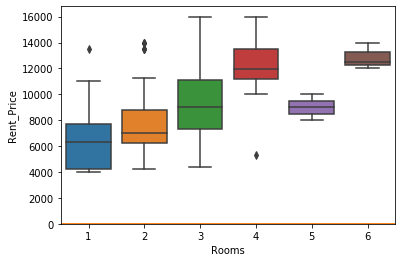

In [17]:
import seaborn as sns
sns.distplot(mh_rent['Rent_Price'],bins=15)

import seaborn as sns
sns.distplot(mh_rent['Price_per_ft2'],bins=15)

sns.boxplot(x='Rooms', y= 'Rent_Price', data=mh_rent)

In [18]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ',  '+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    

map_manhattan_rent

In [19]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)

# add markers to map for rental places
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# FMeasurement ruler icon to establish distnces on map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_clusters2

In [20]:
## kk is the cluster number to explore
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
5,Manhattanville,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Sushi Restaurant,Beer Garden,Coffee Shop,Falafel Restaurant,Bike Trail,Other Nightlife
10,Lenox Hill,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Burger Joint,Deli / Bodega,Gym,Sporting Goods Shop,Thai Restaurant
12,Upper West Side,Italian Restaurant,Bar,Bakery,Vegetarian / Vegan Restaurant,Indian Restaurant,Coffee Shop,Cosmetics Shop,Wine Bar,Mexican Restaurant,Sushi Restaurant
16,Murray Hill,Sandwich Place,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Salon / Barbershop,Burger Joint,French Restaurant,Bar,Italian Restaurant
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Theater,Art Gallery,Seafood Restaurant,American Restaurant,Hotel
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Clothing Store,Chinese Restaurant,Café,Indian Restaurant,Bakery,Seafood Restaurant,Electronics Store
27,Gramercy,Italian Restaurant,Restaurant,Thrift / Vintage Store,Cocktail Bar,Bagel Shop,Coffee Shop,Pizza Place,Mexican Restaurant,Grocery Store,Wine Shop
29,Financial District,Coffee Shop,Hotel,Gym,Wine Shop,Steakhouse,Bar,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center
31,Noho,Italian Restaurant,French Restaurant,Cocktail Bar,Gift Shop,Bookstore,Grocery Store,Mexican Restaurant,Hotel,Sushi Restaurant,Coffee Shop


In [21]:
# A csv file summarized the subway station and the addresses for next step to determine geodata
mh=pd.read_csv(r'C:\Users\Juan Raul Garcia\desktop\NYC_subway_list.csv')
mh.head()

,sub_station,sub_address
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA"
1,57 Street Subway Station,"New York, NY 10106, USA"
2,Broad St,"New York, NY 10005, USA"
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA"
4,5 Av and 53 St,"New York, NY 10022, USA"


In [22]:
#  Add columns 'lat'  and 'long' to mh dataframe - with random temporary numbers to get started
sLength = len(mh['sub_station'])
lat = pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))
mh = mh.assign(lat=lat.values)
mh = mh.assign(long=long.values)

In [23]:
mh=pd.read_csv(r'c:\Users\Juan Raul Garcia\Desktop\MH_subway.csv')
print(mh.shape)
mh.head()

(76, 4)


,sub_station,sub_address,lat,long
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA",40.861857,-73.924509
1,57 Street Subway Station,"New York, NY 10106, USA",40.764250,-73.954525
2,Broad St,"New York, NY 10005, USA",40.730862,-73.987156
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA",40.847991,-73.939785
4,5 Av and 53 St,"New York, NY 10022, USA",40.764250,-73.954525


In [24]:
# removing duplicate rows and creating new set mhsub1
mhsub1=mh.drop_duplicates(subset=['lat','long'], keep="last").reset_index(drop=True)
mhsub1.shape

(22, 4)

In [25]:

mhsub1.tail()

,sub_station,sub_address,lat,long
17,190 Street Subway Station,"Bennett Ave, New York, NY 10040, USA",40.858113,-73.932983
18,59 St-Lexington Av Station,"E 60th St, New York, NY 10065, USA",40.762259,-73.966271
19,57 Street Station,"New York, NY 10019, United States",40.764250,-73.954525
20,14 Street / 8 Av,"New York, NY 10014, United States",40.730862,-73.987156
21,MTA New York City,"525 11th Ave, New York, NY 10018, USA",40.759809,-73.999000


In [26]:
# map subway stations 
# create map of Manhattan using latitude and longitude values obtain previoulsy via Moninatim geolocator
latitude=40.7308619
longitude=-73.9871558

map_mhsub1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mhsub1) 
map_mhsub1

In [27]:

mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3,2100,7500,40.785255,-73.947350
2,West 105th Street,Upper West Side,1.89,4,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2,1450,5000,40.744118,-73.995299


In [28]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_manhattan_rent) 
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_manhattan_rent